In [141]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
from modified_spectral_method import *
from modified_louvain_method import *
from proxy_methods_final import *
from assign_communities import *
import cvxpy as cp
import copy
import matplotlib.pyplot as plt

In [143]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

C:\Users\iChin\AppData\Local\Temp\ipykernel_6060\1307506813.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


In [101]:
ticker = "BRITLD"
bucket = get_bucket(metadata, company_communities, ticker)[0]
date = '2010-11-04'

# Obtain coefficients
coefficients = calculate_proxy_coeff_csra_community(
    prices_data, company_communities, metadata, index_data, bucket, date, use_index=True
)

# Calculate probabilities for the ticker
probabilities, _ = assign_ticker_to_community_bayes(ticker, metadata, company_communities)
print("SANITY CHECK PROBABILITIES", probabilities)

# Calculate proxy if one were to use the weights of each community
proxies_per_community = []
for community_num in range(1, len(company_communities) + 1):
    proxy = calculate_proxy_csra_community(
        ticker, metadata, coefficients, community_num, prices_data, index_data, bucket, date, use_index=True
    )
    proxies_per_community.append(proxy)

print("SANITY CHECK PROXIES PER COMMUNITY", proxies_per_community)

# Calculate the weighted proxy
proxy_weighted = sum(prob * proxy for prob, proxy in zip(probabilities, proxies_per_community))
print(f"Final Weighted Proxy for {ticker} on {date}: {proxy_weighted}")

# Step 1: Assign the ticker to the community with the highest probability
max_prob_index = probabilities.argmax()  # Get the index of the community with the highest probability
assigned_community = max_prob_index + 1  # Communities are 1-indexed
print(f"Assigned Community for {ticker}: Community {assigned_community}")

# Step 2: Calculate the proxy for the assigned community
proxy_assigned_community = calculate_proxy_csra_community(
    ticker, metadata, coefficients, assigned_community, prices_data, index_data, bucket, date, use_index=True
)
print(f"Proxy for Assigned Community {assigned_community}: {proxy_assigned_community}")

# Step 3: Compare the weighted proxy and the assigned community proxy
original_cds_spread = prices_data.loc[date, ticker]
print(f"Original CDS Spread for {ticker} on {date}: {original_cds_spread}")

# Compare Errors
error_weighted = abs(original_cds_spread - proxy_weighted) / original_cds_spread * 100
error_assigned = abs(original_cds_spread - proxy_assigned_community) / original_cds_spread * 100

print(f"Error for Weighted Proxy: {error_weighted:.2f}%")
print(f"Error for Assigned Community Proxy: {error_assigned:.2f}%")


SANITY CHECK PROBABILITIES [0.12198451 0.00764116 0.87037433]
SANITY CHECK PROXIES PER COMMUNITY [201.45417769470492, 281.11397796462904, 170.03681105945282]
Final Weighted Proxy for BRITLD on 2010-11-04: 174.7180013102241
Assigned Community for BRITLD: Community 3
Proxy for Assigned Community 3: 170.03681105945282
Original CDS Spread for BRITLD on 2010-11-04: 164.8055777203959
Error for Weighted Proxy: 6.01%
Error for Assigned Community Proxy: 3.17%


In [133]:
# Initialize a list to store the results
results = []

# Get the list of tickers from metadata
tickers = metadata['Ticker']

# List of dates to evaluate
dates = prices_data.index[:10]  # Adjust the slice as needed

# Loop over each ticker and date
for ticker in tickers:
    for date in dates:
        # Get the bucket for the ticker
        bucket = get_bucket(metadata, company_communities, ticker)[0]

        # Compute coefficients for communities
        coefficients = calculate_proxy_coeff_csra_community(
            prices_data, company_communities, metadata, index_data, bucket, date, use_index=True
        )

        # Calculate probabilities for the ticker
        probabilities, _ = assign_ticker_to_community_bayes(ticker, metadata, company_communities)

        # Compute proxies for all communities
        proxies_per_community = []
        for community_num in range(1, len(company_communities) + 1):
            proxy = calculate_proxy_csra_community(
                ticker, metadata, coefficients, community_num, prices_data, index_data, bucket, date, use_index=True
            )
            proxies_per_community.append(proxy)

        # Calculate the weighted proxy
        proxy_weighted = sum(prob * proxy for prob, proxy in zip(probabilities, proxies_per_community))

        # Assign to the community with the highest probability
        max_prob_index = probabilities.argmax()  # Get the index of the community with the highest probability
        assigned_community = max_prob_index + 1  # Communities are 1-indexed
        proxy_highest_prob = calculate_proxy_csra_community(
            ticker, metadata, coefficients, assigned_community, prices_data, index_data, bucket, date, use_index=True
        )

        # Get the original CDS spread
        original_cds_spread = prices_data.loc[date, ticker]

        # Append results to the list
        results.append({
            'Ticker': ticker,
            'Date': date,
            'Original CDS Spread': original_cds_spread,
            'Weighted Proxy': proxy_weighted,
            'Proxy (Highest Prob Community)': proxy_highest_prob
        })

# Convert results to a DataFrame
comparison_df = pd.DataFrame(results)

# Display the DataFrame
comparison_df


,Ticker,Date,Original CDS Spread,Weighted Proxy,Proxy (Highest Prob Community)
0,AAUK,2010-09-14,179.666667,107.931720,103.899580
1,AAUK,2010-09-15,175.666667,108.717307,104.409610
2,AAUK,2010-09-16,174.666667,107.758115,103.144257
3,AAUK,2010-09-17,169.500000,105.646775,101.150727
4,AAUK,2010-09-20,171.833333,106.506670,102.238354
...,...,...,...,...,...
3175,ZINCO,2010-09-21,95.376623,360.966614,361.653338
3176,ZINCO,2010-09-22,107.046074,356.968403,357.367045
3177,ZINCO,2010-09-23,112.666667,360.772160,360.235614
3178,ZINCO,2010-09-24,110.750000,370.792172,371.243943


In [134]:
def compute_error_percentage(row):
    """
    Compute the error percentage for a single row in the DataFrame.

    Parameters:
    row (pd.Series): A single row of the comparison_df DataFrame.

    Returns:
    dict: A dictionary containing error percentages for Weighted Proxy and Proxy (Highest Prob Community).
    """
    original = row['Original CDS Spread']
    weighted_proxy = row['Weighted Proxy']
    highest_prob_proxy = row['Proxy (Highest Prob Community)']

    # Calculate absolute percentage errors
    error_weighted = abs((original - weighted_proxy) / original) * 100 if original != 0 else None
    error_highest_prob = abs((original - highest_prob_proxy) / original) * 100 if original != 0 else None

    return {
        'Error % (Weighted)': error_weighted,
        'Error % (Highest Prob)': error_highest_prob
    }


In [135]:
# Apply the function to each row
error_data = comparison_df.apply(compute_error_percentage, axis=1)

# Convert the error data into a DataFrame and concatenate with the original DataFrame
error_df = pd.DataFrame(list(error_data))
comparison_error_df = pd.concat([comparison_df, error_df], axis=1)

# Display the updated DataFrame
comparison_error_df


,Ticker,Date,Original CDS Spread,Weighted Proxy,Proxy (Highest Prob Community),Error % (Weighted),Error % (Highest Prob)
0,AAUK,2010-09-14,179.666667,107.931720,103.899580,39.926687,42.170920
1,AAUK,2010-09-15,175.666667,108.717307,104.409610,38.111590,40.563789
2,AAUK,2010-09-16,174.666667,107.758115,103.144257,38.306423,40.947944
3,AAUK,2010-09-17,169.500000,105.646775,101.150727,37.671519,40.324055
4,AAUK,2010-09-20,171.833333,106.506670,102.238354,38.017457,40.501443
...,...,...,...,...,...,...,...
3175,ZINCO,2010-09-21,95.376623,360.966614,361.653338,278.464451,279.184464
3176,ZINCO,2010-09-22,107.046074,356.968403,357.367045,233.471736,233.844139
3177,ZINCO,2010-09-23,112.666667,360.772160,360.235614,220.211976,219.735752
3178,ZINCO,2010-09-24,110.750000,370.792172,371.243943,234.801058,235.208978


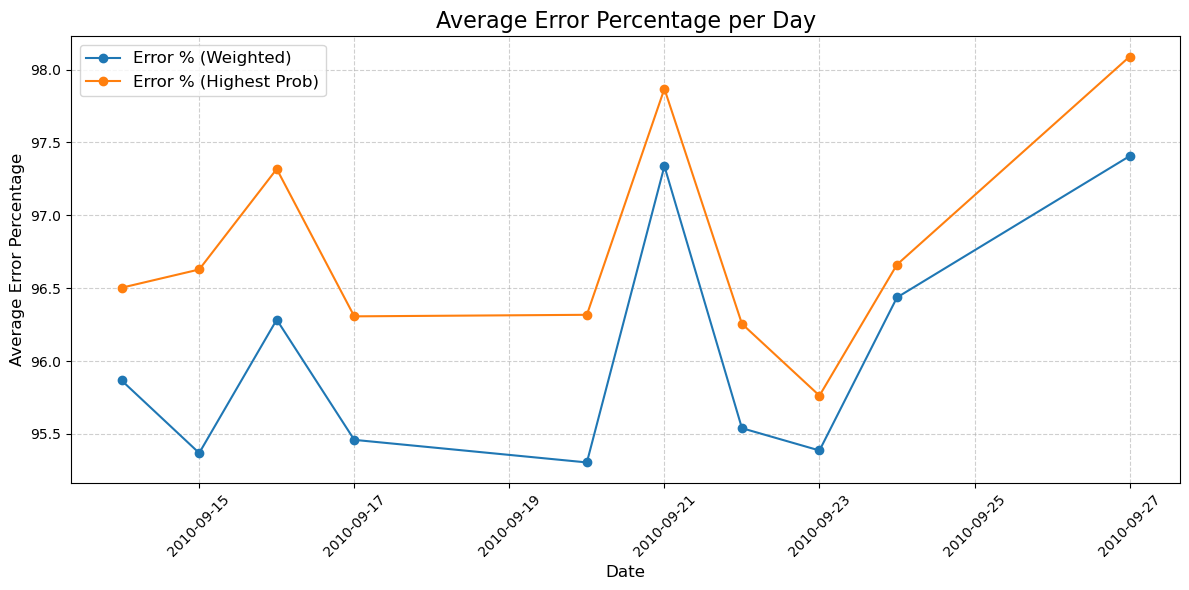

In [136]:
# Group by the 'Date' column and calculate the mean of error percentages
average_error_per_day = comparison_error_df.groupby('Date')[['Error % (Weighted)', 'Error % (Highest Prob)']].mean()

# Reset the index for plotting
average_error_per_day = average_error_per_day.reset_index()

# Plot the average errors per day
plt.figure(figsize=(12, 6))
plt.plot(average_error_per_day['Date'], average_error_per_day['Error % (Weighted)'], label='Error % (Weighted)', marker='o')
plt.plot(average_error_per_day['Date'], average_error_per_day['Error % (Highest Prob)'], label='Error % (Highest Prob)', marker='o')

# Add title and labels
plt.title('Average Error Percentage per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Error Percentage', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(fontsize=12)

# Show grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

In [122]:
comparison_error_df.iloc[100:150]

,Ticker,Date,Original CDS Spread,Weighted Proxy,Proxy (Highest Prob Community),Error % (Weighted),Error % (Highest Prob)
100,AUST,2010-09-15,68.012646,126.717336,126.717336,86.314376,86.314376
101,AUST,2010-09-16,68.444560,128.321595,128.321595,87.482532,87.482532
102,AVLN,2010-09-14,109.000000,200.826526,188.940473,84.244519,73.339884
103,AVLN,2010-09-15,108.833333,202.759448,191.450568,86.302709,75.911701
104,AVLN,2010-09-16,109.000000,200.161105,189.349766,83.634041,73.715382
105,AWLN-AngWatServ,2010-09-14,77.833790,98.782068,100.701377,26.914117,29.380024
106,AWLN-AngWatServ,2010-09-15,78.057498,100.903352,103.084708,29.267981,32.062531
107,AWLN-AngWatServ,2010-09-16,76.515296,101.558295,104.143216,32.729402,36.107708
108,AXAF,2010-09-14,110.333333,269.888331,308.024605,144.611781,179.176379
109,AXAF,2010-09-15,110.833333,269.826661,307.528806,143.452626,177.469599


In [123]:
# Initialize counters
weighted_better_count = 0
total_count = len(comparison_df)

# Loop through the DataFrame to compare errors
for _, row in comparison_df.iterrows():
    original_cds = row['Original CDS Spread']
    weighted_proxy = row['Weighted Proxy']
    highest_prob_proxy = row['Proxy (Highest Prob Community)']

    # Calculate absolute errors
    error_weighted = abs(original_cds - weighted_proxy)
    error_highest_prob = abs(original_cds - highest_prob_proxy)

    # Check if weighted proxy is better
    if error_weighted < error_highest_prob:
        weighted_better_count += 1

# Calculate the percentage
percentage_weighted_better = (weighted_better_count / total_count) * 100

# Output the result
print(f"Percentage of cases where Weighted Proxy performs better: {percentage_weighted_better:.2f}%")


Percentage of cases where Weighted Proxy performs better: 52.20%


In [ ]:
ticker = "BRITLD"
bucket = get_bucket(metadata, company_communities, ticker)[0]
date = '2010-11-04'

# Obtain coefficients
coefficients = calculate_proxy_coeff_csra_community(
    prices_data, company_communities, metadata, index_data, bucket, date, use_index = True
)

# Calculate probabilities for the ticker
probabilities, _ = assign_ticker_to_community_bayes(ticker, metadata, company_communities)
print("SANITY CHECK PROBABILITIES", probabilities)

# Calculate proxy if one were to use the weights of each community
proxies_per_community = []
for community_num in range(1, len(company_communities) + 1):
    proxy = calculate_proxy_csra_community(
        ticker, metadata, coefficients, community_num, prices_data, index_data, bucket, date, use_index=True
    )
    proxies_per_community.append(proxy)

print("SANITY CHECK PROXIES PER COMMUNITY", proxies_per_community)

proxy_weighted = 0

# Loop through the probabilities and community-specific proxies
for prob, proxy in zip(probabilities, proxies_per_community):
    # Multiply probability by proxy and add to the final proxy
    proxy_weighted += prob * proxy

print(f"Final Proxy for {ticker} on {date}: {proxy_weighted}")

# Initialize a list to store the results
results = []

# Get the first 50 tickers from metadata
tickers = metadata['Ticker'] 

# List of dates to evaluate
dates = prices_data.index[:1]

# Loop over each ticker and date
for ticker in tickers:
    for date in dates:
        # Get the bucket for the ticker
        bucket = get_bucket(metadata, company_communities, ticker)[0]

        # Compute coefficients for communities
        coefficients = calculate_proxy_coeff_csra_community(
            prices_data, company_communities, metadata, index_data, bucket, date, use_index=True
        )

        # Calculate probabilities for the ticker
        probabilities, _ = assign_ticker_to_community_bayes(ticker, metadata, company_communities)

        # Compute proxies for all communities and weighted proxy
        proxies_per_community = []
        for community_num in range(1, len(company_communities) + 1):
            proxy = calculate_proxy_csra_community(
                ticker, metadata, coefficients, community_num, prices_data, index_data, bucket, date, use_index=True
            )
            proxies_per_community.append(proxy)

        proxy_weighted = sum(prob * proxy for prob, proxy in zip(probabilities, proxies_per_community))

        # Compute the community-specific proxy (no weights)
        original_community = get_original_community(ticker, company_communities)
        proxy_no_weights = calculate_proxy_csra_community(
            ticker, metadata, coefficients, original_community, prices_data, index_data, bucket, date, use_index=True
        )

        # Get the original CDS spread
        original_cds_spread = prices_data.loc[date, ticker]

        # Append results to the list
        results.append({
            'Ticker': ticker,
            'Date': date,
            'Original CDS Spread': original_cds_spread,
            'Weighted Proxy': proxy_weighted,
            'Community Proxy (No Weights)': proxy_no_weights
        })

# Convert results to a DataFrame
comparison_df = pd.DataFrame(results)
comparison_df

In [ ]:
def compute_error_percentage(row):
    """
    Compute the error percentage for a single row in the DataFrame.

    Parameters:
    row (pd.Series): A single row of the comparison_df DataFrame.

    Returns:
    dict: A dictionary containing error percentages for Weighted Proxy and Community Proxy (No Weights).
    """
    original = row['Original CDS Spread']
    weighted_proxy = row['Weighted Proxy']
    no_weights_proxy = row['Community Proxy (No Weights)']

    # Calculate absolute percentage errors
    error_weighted = abs((original - weighted_proxy) / original) * 100 if original != 0 else None
    error_no_weights = abs((original - no_weights_proxy) / original) * 100 if original != 0 else None

    return {
        'Error % (Weighted)': error_weighted,
        'Error % (No Weights)': error_no_weights
    }


In [115]:
# Initialize counters
weighted_better_count = 0
total_count = len(comparison_df)

# Loop through the DataFrame to compare errors
for _, row in comparison_df.iterrows():
    original_cds = row['Original CDS Spread']
    weighted_proxy = row['Weighted Proxy']
    no_weights_proxy = row['Community Proxy (No Weights)']

    # Calculate absolute errors
    error_weighted = abs(original_cds - weighted_proxy)
    error_no_weights = abs(original_cds - no_weights_proxy)

    # Check if weighted proxy is better
    if error_weighted < error_no_weights:
        weighted_better_count += 1

# Calculate the percentage
percentage_weighted_better = (weighted_better_count / total_count) * 100

# Output the result
print(f"Percentage of cases where Weighted Proxy performs better: {percentage_weighted_better:.2f}%")


KeyError: 'Community Proxy (No Weights)'